# Econ 1923 - Product Differentiation Project

## 1 Preparation
### 1.1 Obtaining the data
Create a data set containing nutrition information about cereal boxes. You can use all sources including the nutrition APIs, stores web pages, actual grocery stores, your pantry, etc.
At the end of this process, you should have a dataframe that contains as many cereal boxes as possible and for each, you should have several nutritional facts and (ideally) serving sizes (cups or grams).
The result of this part can be several dataframes, each resulting from the different data sources that you used.

Sources: Edemam API, GitHub JSON Files, personal cereals


In [1]:
#Importing packages
import requests, json, time
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
%run ../APIkeys.py

In [2]:
app_id = os.environ['EDAMAM_API_id']
key = os.environ['EDAMAM_API_key']
baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+app_id+'&app_key='+key+'&upc='
endURL = '&nutrition-type=cooking&category=packaged-foods'

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
def checkUPC_edamam(upc):
    # This function is called checkUPC_V2 in previous notebooks
    
    edamam_id = os.environ['EDAMAM_API_id']
    edamam_key = os.environ['EDAMAM_API_key']
    edamam_baseURL = 'https://api.edamam.com/api/food-database/v2/parser?app_id='+edamam_id+'&app_key='+edamam_key+'&upc='
    edamam_endURL = '&nutrition-type=cooking&category=packaged-foods'
    url = edamam_baseURL + upc + edamam_endURL
    info = requests.get(url).json()
    if 'error' in info:
        return info
    else:
        answer = info['hints'][0]['food']['nutrients']
        
        sizeList = info['hints'][0]['food']['servingSizes']
        n = len(sizeList)
        for i in range(n):
            if sizeList[i]['label'] == 'Gram':
                answer['servingSize_gram'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
            if sizeList[i]['label'] == 'Cup':
                answer['servingSize_cup'] = info['hints'][0]['food']['servingSizes'][i]['quantity']
        
        answer['label'] = info['hints'][0]['food']['label']
        answer['upc'] = upc
        return answer

In [73]:
#We add a 2 second interval between each call to stay under the limit for the Edamam API.

def multiUPC_edamam(shelf, verbose = False, leftovers = False, source=""):
    # This function is called multiUPC_V2 in previous notebooks
    
    # Shelf - a list of strings, each representing a UPC code
    # verbose - boolean telling the function whether to print found/unfound UPCs
    # leftovers - boolean telling the function whetehr to output the 
    
    found = []    #container for information on found UPCS
    unfound = []  #container for unfound UPCs
    
    # loop over UPCs in shelf
    for upc in shelf:
        info = checkUPC_edamam(upc)
        
        if 'error' in info:
            unfound.append(upc) #add to the unfound container
            if verbose:
                print('UPC ',upc, ' does not exist in the API\'s data base')
                time.sleep(2)
        
        else:
            if verbose:
                print('UPC ',upc, ' exists in the API\'s data base')
                time.sleep(2)
            found.append(info)
    
    # turn the dictionary found into a Dataframe
    if len(found)>0:
        df_found = pd.DataFrame(found)
    else:
        df_found = pd.DataFrame()
    
    # add a source column
    df_found["dataSource"] = pd.Series([source for i in range(len(df_found.index))])
    
    
    # return the values of found and unfound (optional)
    if leftovers:
        return df_found,unfound
    else:
        return df_found   

In [5]:
#reading excel and csv files containing states' WIC 
#Approved Products Lists (APLs) and filtering down to cereal UPCs

df_IL = pd.read_excel('IL_WIC_APL.xlsx') #Illinois
df_IL = df_IL.drop([174], axis=0)
df_IL = df_IL.reset_index(drop=True)

df_MA = pd.read_excel('MA_WIC_APL.xlsx')
df_MA = df_MA[df_MA['Category Name']=='Breakfast Cereal'] #Massachusetts
df_MA = df_MA.reset_index(drop=True)

df_MN = pd.read_excel('MN_WIC_APL.xlsx')#Minnesota

df_NE = pd.read_excel('NE_WIC_APL.xlsx')#Nebraska

df_NV = pd.read_csv('NV_WIC_APL.csv')#Nevada

df_NY = pd.read_excel('NY_WIC_APL.xlsx')#New York S
df_NY = df_NY[df_NY['Category']=='Breakfast Cereal ']
df_NY = df_NY.reset_index(drop=True)

In [6]:
#Isolating UPCs into string arrays and combining
IL_UPCs = []
for i in range(0,len(df_IL['UPC/PLU Code'])-1):
    IL_UPCs.append(df_IL['UPC/PLU Code'][i][7:18])
    
MA_UPCs = []
for i in range(0,len(df_MA['UPC'])-1):
    MA_UPCs.append(str(df_MA['UPC'][i]))

MN_UPCs = []
for i in range(0,len(df_MN['UPC_PLU'])-1):
    MN_UPCs.append(str(df_MN['UPC_PLU'][i]))
    
NE_UPCs = []
for i in range(0,len(df_NE['UPC'])-1):
    NE_UPCs.append(str(df_NE['UPC'][i]))

NV_UPCs = []
for i in range(0,len(df_NV['UPC'])-1):
    if len(df_NV['UPC'][i])==14:
        NV_UPCs.append(df_NV['UPC'][i][2:13])
    elif len(df_NV['UPC'][i])==15:
        NV_UPCs.append(df_NV['UPC'][i][3:14])

NY_UPCs = []
for i in range(0,len(df_NY['UPC/PLU Number'])-1):
    if len(str(df_NY['UPC/PLU Number'][i]))==11:
        NY_UPCs.append(str(df_NY['UPC/PLU Number'][i]))
    elif len(str(df_NY['UPC/PLU Number'][i]))==12:
        NY_UPCs.append(str(df_NY['UPC/PLU Number'][i])[1:12])
        
UPCs = IL_UPCs + MA_UPCs + MN_UPCs + NE_UPCs + NV_UPCs + NY_UPCs #combining
UPCs = list(set(UPCs)) #removes duplicate UPCs, and then coerces into a list

In [75]:
found, unfound = multiUPC_edamam(UPCs, verbose = True, leftovers = True, source="Edamam_API")

UPC  884912181701  exists in the API's data base
UPC  36800291881  exists in the API's data base
UPC  16000170124  does not exist in the API's data base
UPC  41735088635  does not exist in the API's data base
UPC  41735158437  does not exist in the API's data base
UPC  42187428734  does not exist in the API's data base
UPC  18894110200  exists in the API's data base
UPC  38000245664  does not exist in the API's data base
UPC  16000171046  does not exist in the API's data base
UPC  30000320730  exists in the API's data base
UPC  16000666603  exists in the API's data base
UPC  11161159599  exists in the API's data base
UPC  72543910245  does not exist in the API's data base
UPC  38000049200  exists in the API's data base
UPC  36800149724  exists in the API's data base
UPC  70784471983  exists in the API's data base
UPC  884912105219  exists in the API's data base
UPC  42400146322  exists in the API's data base
UPC  75450033588  exists in the API's data base
UPC  75450075472  exists in th

UPC  50700286433  exists in the API's data base
UPC  41735088611  does not exist in the API's data base
UPC  15400820998  exists in the API's data base
UPC  884912259363  exists in the API's data base
UPC  16000176829  exists in the API's data base
UPC  64144080373  exists in the API's data base
UPC  88267070495  does not exist in the API's data base
UPC  41268155804  does not exist in the API's data base
UPC  38000207501  exists in the API's data base
UPC  21333061018  exists in the API's data base
UPC  41497538485  exists in the API's data base
UPC  51933342637  does not exist in the API's data base
UPC  38000318467  exists in the API's data base
UPC  38000199554  exists in the API's data base
UPC  42400098003  exists in the API's data base
UPC  21130281534  exists in the API's data base
UPC  41735158420  does not exist in the API's data base
UPC  36800188631  exists in the API's data base
UPC  41735022127  does not exist in the API's data base
UPC  41303002124  exists in the API's d

UPC  88267090998  does not exist in the API's data base
UPC  30000064429  exists in the API's data base
UPC  41270830294  exists in the API's data base
UPC  21333060813  does not exist in the API's data base
UPC  99482438975  exists in the API's data base
UPC  41735158758  does not exist in the API's data base
UPC  38000001208  exists in the API's data base
UPC  688267070495  exists in the API's data base
UPC  42187029245  does not exist in the API's data base
UPC  70253298776  exists in the API's data base
UPC  78742183961  does not exist in the API's data base
UPC  41268202676  exists in the API's data base
UPC  41735022103  does not exist in the API's data base
UPC  884912014276  exists in the API's data base
UPC  21859046001  exists in the API's data base
UPC  50700561196  exists in the API's data base
UPC  16000103719  exists in the API's data base
UPC  84912359162  does not exist in the API's data base
UPC  16000275058  exists in the API's data base
UPC  78742230337  exists in th

UPC  41512093357  exists in the API's data base
UPC  16000169623  does not exist in the API's data base
UPC  42187408750  does not exist in the API's data base
UPC  884912003928  exists in the API's data base
UPC  86341170541  exists in the API's data base
UPC  36800317581  exists in the API's data base
UPC  38000469541  exists in the API's data base
UPC  36800558168  exists in the API's data base
UPC  41497530069  exists in the API's data base
UPC  38000596674  exists in the API's data base
UPC  70253298790  exists in the API's data base
UPC  42400068006  does not exist in the API's data base
UPC  99771333102  does not exist in the API's data base
UPC  16000275676  exists in the API's data base
UPC  93476000183  does not exist in the API's data base
UPC  49705105351  does not exist in the API's data base
UPC  41270041461  does not exist in the API's data base
UPC  41270448581  does not exist in the API's data base
UPC  50700271897  does not exist in the API's data base
UPC  7025327999

UPC  16000410770  exists in the API's data base
UPC  49705005545  does not exist in the API's data base
UPC  18894110644  exists in the API's data base
UPC  16000898257  does not exist in the API's data base
UPC  75450081756  exists in the API's data base
UPC  11225124075  exists in the API's data base
UPC  30000012109  exists in the API's data base
UPC  42400178057  exists in the API's data base
UPC  11150100687  exists in the API's data base
UPC  70038342878  does not exist in the API's data base
UPC  38000200687  does not exist in the API's data base
UPC  41190756742  does not exist in the API's data base
UPC  49705005538  does not exist in the API's data base
UPC  13130006989  exists in the API's data base
UPC  78742075648  exists in the API's data base
UPC  41270830256  does not exist in the API's data base
UPC  42400178019  exists in the API's data base
UPC  41268108275  exists in the API's data base
UPC  84912377142  does not exist in the API's data base
UPC  73296313604  exists

UPC  21333060943  exists in the API's data base
UPC  35826003690  does not exist in the API's data base
UPC  41303059852  exists in the API's data base
UPC  38000016219  exists in the API's data base
UPC  15400838108  exists in the API's data base
UPC  11153040607  does not exist in the API's data base
UPC  41735022134  does not exist in the API's data base
UPC  72400060182  exists in the API's data base
UPC  42400001058  exists in the API's data base
UPC  93476000190  does not exist in the API's data base
UPC  16000163928  does not exist in the API's data base
UPC  41270812962  exists in the API's data base
UPC  78742056821  exists in the API's data base
UPC  50700742953  does not exist in the API's data base
UPC  688267169663  exists in the API's data base
UPC  23933002019  exists in the API's data base
UPC  78742147048  exists in the API's data base
UPC  36800413511  exists in the API's data base
UPC  11153040621  does not exist in the API's data base
UPC  41303001615  exists in the

UPC  78742122076  exists in the API's data base
UPC  30000567661  exists in the API's data base
UPC  88267078675  does not exist in the API's data base
UPC  42400025542  exists in the API's data base
UPC  88267169878  does not exist in the API's data base
UPC  75130414072  exists in the API's data base
UPC  93476000206  does not exist in the API's data base
UPC  41270830744  exists in the API's data base
UPC  49705017937  exists in the API's data base
UPC  23627050142  does not exist in the API's data base
UPC  91669403034  does not exist in the API's data base
UPC  74807099130  exists in the API's data base
UPC  884912014252  exists in the API's data base
UPC  30000040508  exists in the API's data base
UPC  15400874410  exists in the API's data base
UPC  78742140988  exists in the API's data base
UPC  88267064517  does not exist in the API's data base
UPC  84912359421  does not exist in the API's data base
UPC  70038618461  does not exist in the API's data base
UPC  20794011760  does 

In [85]:
Cereals = pd.DataFrame(found)
Missing = pd.DataFrame(unfound)
len(Missing)

341

In [87]:
#Since calling all the UPCs takes a long time, we're saving the 
#dataframe into an excel sheet for quicker loader later on
Cereals.to_excel("Cereals_Raw.xlsx", sheet_name='Cereal Data')
Missing.to_excel("Edamam_Missing.xlsx", sheet_name='Missing UPCs')

In [261]:
Cereals = pd.read_excel('Cereals_Raw.xlsx')
Cereals = Cereals.drop(columns='Unnamed: 0',axis=1)#removing index from added by excel format

#The dataframe appears to still have some duplicate cereal 
#labels, so we're dropping them and resetting the index
Cereals = Cereals.drop_duplicates(subset=['label'],keep='last').reset_index().drop(columns='index',axis=1)

# rename columns
Cereals = Cereals.rename(columns={"ENERC_KCAL": "CALORIES",
                                  "NA": "SALT",
                                  "CHOCDF": "CARB", 
                                  "PROCNT": "PROTEIN",
                                  "P": "PHOSPHORUS",
                                  "FE": "IRON",
                                  "CA": "CALCIUM",
                                  "FIBTG": "FIBER"})

### 1.2 Cleaning and re-scaling
Various data sources may contain different variable names, different units, or different serving sizes. Also, missing values can be an issue. Here, you are asked to:
- Make sure that variable names in all dataframes that you created match.
- Make sure that all nutritional measurements in all data frames are the same (e.g. per cup or per 100gr).
- Merge the different data sources.
 
The final data set should include a column indicating the source of the observation (i.e. is it from the API, entered manually from a certain store, etc.).

### 1.3 Descriptive statistics
Create a table with descriptive statistics (Mean, Median, standard deviation, range, number of missing observations, etc.

In [262]:
while Cereals.FIBER.max() > Cereals.FIBER.mean()+4*Cereals.FIBER.std():
    Cereals = Cereals.drop(Cereals.FIBER.idxmax())
while Cereals.CALCIUM.max() > Cereals.CALCIUM.mean()+4*Cereals.CALCIUM.std():
    Cereals = Cereals.drop(Cereals.CALCIUM.idxmax())

In [263]:
Cereals[nutrition_facts].describe()

,CALORIES,FAT,SALT,CARB,FIBER,SUGAR,SUGAR.added,PROTEIN,PHOSPHORUS,IRON,CALCIUM
count,528.000000,525.000000,527.000000,528.000000,527.000000,522.000000,89.000000,528.000000,337.000000,465.000000,413.000000
mean,361.318639,2.740019,428.694311,79.073863,7.522519,11.227964,16.122472,9.036248,274.423329,28.020242,157.493092
std,49.841635,2.407135,277.236684,11.167702,4.402805,7.874407,5.303938,3.252545,139.301711,10.416319,170.820210
min,40.576827,0.000000,0.000000,9.721532,0.000000,0.000000,2.500000,0.000000,0.000000,2.300000,0.000000
25%,350.000000,0.000000,259.387681,77.427987,3.571429,3.570000,13.200000,7.140000,169.000000,27.930000,0.000000
50%,367.000000,1.881278,488.000000,81.250000,8.900000,10.260000,18.200001,8.973537,273.000000,28.930000,36.363636
75%,385.000000,4.690000,585.500000,84.657509,10.582189,18.750000,20.000000,10.582189,352.739619,30.860001,333.000000
max,436.000000,10.910000,1484.151949,91.712301,19.200001,32.142857,26.700001,31.250000,705.479239,62.392097,727.000000


## 2 Market Analysis
### 2.1 Visualisation
Create scatter plots of the data. Here you have to try several pairs of characteristics on which it seems like the products are more differentiated. This is a visual exercise but you can support your claims by looking at standard deviations and correlations.

In [156]:
#making a short list of nutrition facts (you can make your own!)

nutrition_facts = ['CALORIES', 'FAT', 'SALT', 'CARB', 'FIBER', 'SUGAR', 'SUGAR.added', 'PROTEIN', 'PHOSPHORUS', 'IRON', 'CALCIUM']

In [250]:
#Correlation Matrix
Cereals[nutrition_facts].corr()

,CALORIES,FAT,SALT,CARB,FIBER,SUGAR,SUGAR.added,PROTEIN,PHOSPHORUS,IRON,CALCIUM
CALORIES,1.000000,0.278042,0.251668,0.791142,-0.017393,0.179090,-0.276732,0.264177,-0.044572,0.094281,0.053392
FAT,0.278042,1.000000,-0.114327,-0.165078,0.375478,0.130745,-0.062348,0.298432,0.266821,-0.154592,0.207011
SALT,0.251668,-0.114327,1.000000,0.242359,-0.267414,-0.242588,-0.649509,-0.052182,0.114039,0.350951,0.417679
CARB,0.791142,-0.165078,0.242359,1.000000,-0.011065,0.273787,0.289837,-0.026563,-0.022877,0.307223,-0.169758
FIBER,-0.017393,0.375478,-0.267414,-0.011065,1.000000,0.156951,0.358499,0.437216,0.727112,0.235939,-0.087126
SUGAR,0.179090,0.130745,-0.242588,0.273787,0.156951,1.000000,0.982964,-0.095681,-0.201044,0.209123,-0.404938
SUGAR.added,-0.276732,-0.062348,-0.649509,0.289837,0.358499,0.982964,1.000000,-0.159682,0.201761,0.103569,-0.429902
PROTEIN,0.264177,0.298432,-0.052182,-0.026563,0.437216,-0.095681,-0.159682,1.000000,0.341783,0.027574,0.120124
PHOSPHORUS,-0.044572,0.266821,0.114039,-0.022877,0.727112,-0.201044,0.201761,0.341783,1.000000,0.346950,0.252257
IRON,0.094281,-0.154592,0.350951,0.307223,0.235939,0.209123,0.103569,0.027574,0.346950,1.000000,0.049331


In [ ]:
# FAT, Suger Add
# Sugar Add, FAT

# Protein, Choc
# Salt, Protein
# Suger, Protein
# Iron, Protein

# CAL, CA

# Fiber, CA
# CA, Fiber


# Choc, Fiber

### 2.2 K-Means clustering
Using the K-means clustering technique analyze the degree of product differentiation. Based on descriptive statistics, data availability, and scatter plots, choose pairs of features (i.e., nutrition facts) on which you believe the sellers differentiate themselves. Quantify your answer. You should try different K parameters. Report the goodness of fit (total sum of errors). *Instead of different pairs of features you can focus on the same pair and compare different locations or different supermarkets.*

In [251]:
# Scaling to a unit interval

def  rescaleFeatures(df_in):
    # This function rescale all the columns in dataframe df_in to be
    # between 0 and 1. It returns the scaled dataframe as well as the
    # lists of minimum and the maximum (so we can rescale back)

    df_out = df_in # first, we make a copy of the original df
    m = df_out.min() # a list of minimums for all columns in df_in
    M = df_out.max() # a list of maximums for all columns in df_in
    for i in range(len(df_out.columns)):
        df_out.iloc[:,i] = (df_out.iloc[:,i] - m[i])/(M[i]-m[i])
    
    return df_out,m,M

In [99]:
def upscaleCentroids(centroids_in,m,M):
    # This function takes the list of centroids resulting from a Kmeans procedure
    # that was perfomed on a scaled data set and scale these centroids back to
    # the original values. This function is a little bit cumbersome because of 
    # the weird structure of the output from the kmeans package. 
    
    centroid_out = centroids_in
    n_centroids = len(centroids_in) 
    n_features = len(centroids_in[0])
    for i in range(n_centroids):
        for j in range(n_features):
            centroid_out[i][j] = (centroid_out[i][j] )*(M[j]-m[j]) + m[j] 
    
    return centroid_out

#### 3-way Comparison, Calcium-Fiber-Calories

In [264]:
features_a = ['CALCIUM','CALORIES']
small_a = Cereals[features_a].dropna()

features_b = ['CALORIES','FIBER']
small_b = Cereals[features_b].dropna()

features_c = ['FIBER','CALCIUM']
small_c = Cereals[features_c].dropna()

In [265]:
# finding the minimum and maximum of the column of a Dataframe
m_a = small_a.min()
M_a = small_a.max()

m_b = small_b.min()
M_b = small_b.max()

m_c = small_c.min()
M_c = small_c.max()

In [266]:
pd.options.mode.chained_assignment = None  # default='warn'
df_a,m_a,M_a = rescaleFeatures(small_a)
df_b,m_b,M_b = rescaleFeatures(small_b)
df_c,m_c,M_c = rescaleFeatures(small_c)

In [267]:
k = 5
kmeans_a = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(df_a)
kmeans_b = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(df_b)
kmeans_c = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(df_c)

In [268]:
centroids_a = upscaleCentroids(kmeans_a.cluster_centers_,m_a,M_a)
centroids_b = upscaleCentroids(kmeans_b.cluster_centers_,m_b,M_b)
centroids_c = upscaleCentroids(kmeans_c.cluster_centers_,m_c,M_c)

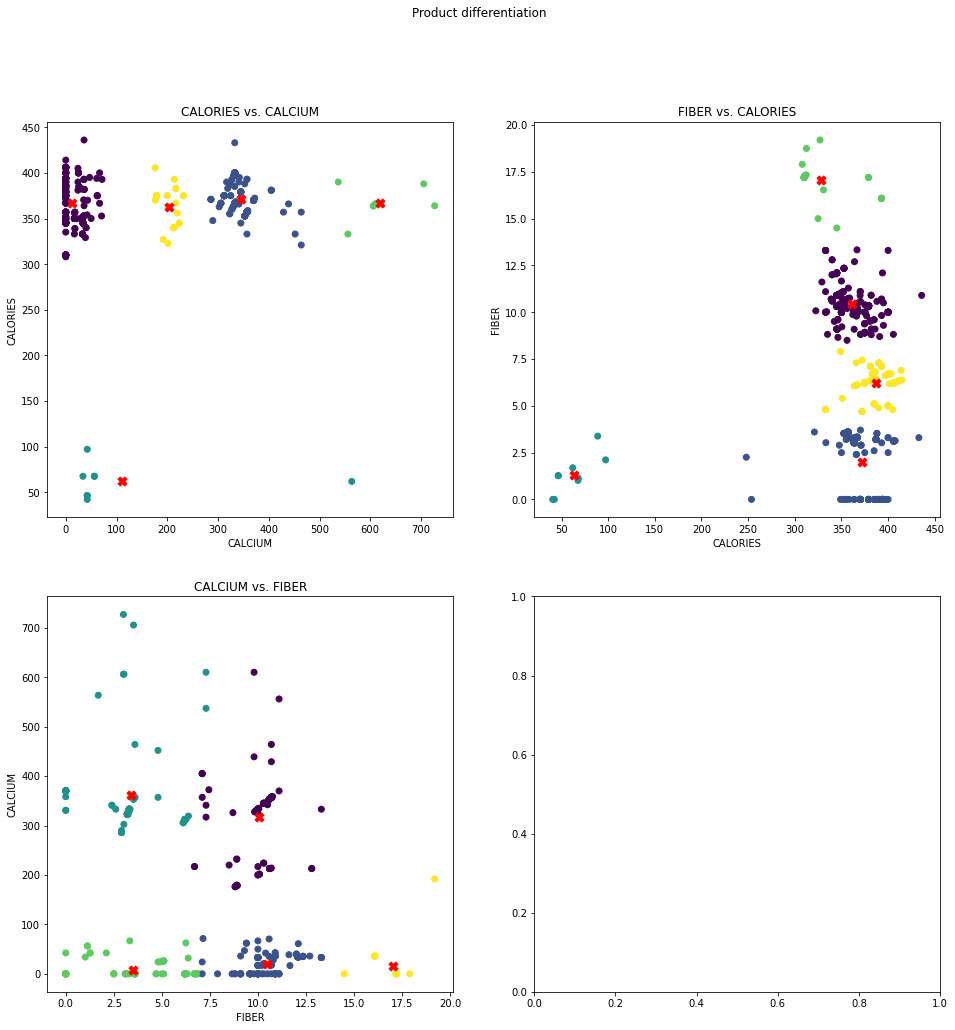

In [270]:
fig, axs = plt.subplots(2, 2, squeeze=False, figsize=(16,16)) 
#subplot_kw = dict(polar = True)

axs[0,0].scatter(data=Cereals.dropna(subset=features_a), x=features_a[0], y=features_a[1],c=kmeans_a.labels_)
axs[0,0].scatter(centroids_a[:,0], centroids_a[:,1],marker="X", c="r", s=80, label="centroids")
axs[0,0].set_title("CALORIES vs. CALCIUM")
axs[0,0].set_xlabel("CALCIUM")
axs[0,0].set_ylabel("CALORIES")

axs[0,1].scatter(data=Cereals.dropna(subset=features_b), x=features_b[0], y=features_b[1],c=kmeans_b.labels_)
axs[0,1].scatter(centroids_b[:,0], centroids_b[:,1],marker="X", c="r", s=80, label="centroids")
axs[0,1].set_title("FIBER vs. CALORIES")
axs[0,1].set_xlabel("CALORIES")
axs[0,1].set_ylabel("FIBER")

axs[1,0].scatter(data=Cereals.dropna(subset=features_c), x=features_c[0], y=features_c[1],c=kmeans_c.labels_)
axs[1,0].scatter(centroids_c[:,0], centroids_c[:,1],marker="X", c="r", s=80, label="centroids")
axs[1,0].set_title("CALCIUM vs. FIBER")
axs[1,0].set_xlabel("FIBER")
axs[1,0].set_ylabel("CALCIUM")


fig.suptitle('Product differentiation')
plt.show()

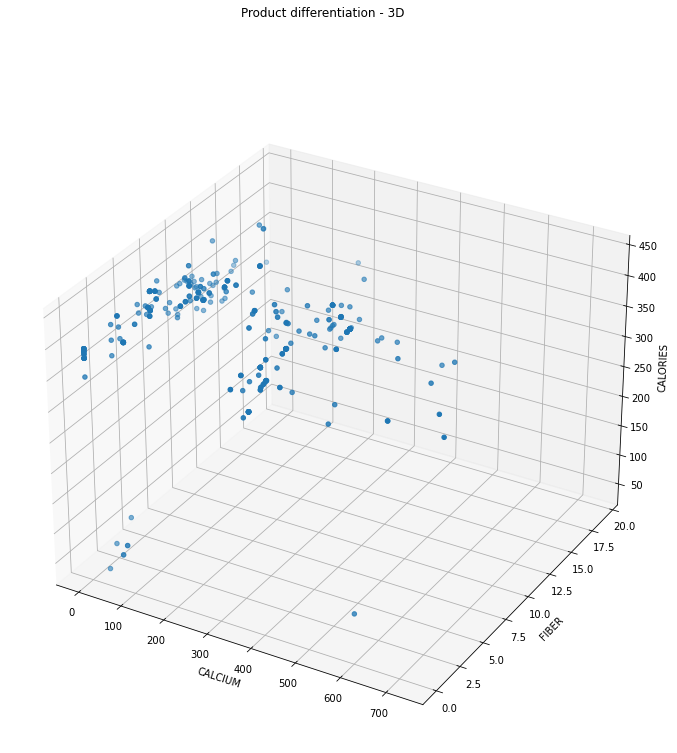

In [271]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection ="3d")

ax.scatter( Cereals['CALCIUM'], Cereals['FIBER'],Cereals['CALORIES'])

ax.set_xlabel('CALCIUM')
ax.set_ylabel('FIBER')
ax.set_zlabel('CALORIES')

fig.suptitle('Product differentiation - 3D')
plt.show()

In [259]:
# Trying k=1..12

inertia = []
n_clusters = []
for i in range(1,13):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0).fit(df_a)
    inertia.append(kmeans.inertia_)
    n_clusters.append(i)
    
inertia

[36.67290225355368,
 9.195157731684976,
 4.994565085165273,
 3.431019488873407,
 2.3476388286085217,
 1.6509648419653173,
 1.1522241874086303,
 0.9093740722003241,
 0.7920993536669879,
 0.6864778492521154,
 0.6012995130202621,
 0.5243521962765674]

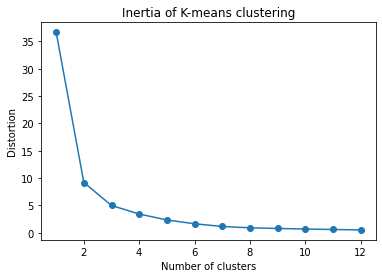

In [260]:
plt.plot(n_clusters,inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("Inertia of K-means clustering")
plt.show()

## 3 Conclusions
Summarize your findings and draw conclusions from them. What can you recommend to cereal producers on the market? Do you find this market to be saturated? Here, I leave it to you to analyze your findings as you see fit. Given all the effort you have put, This section should be as very important.